# Initial results DAS protocol vs DAS using vanilla DHT protocol

## DAS protocol

* The network is formed of a single builder that is generating the block with all samples and `N` nodes distributed between validators and regular nodes.
* Builder knows all the validators
* All nodes have a unique 256 bits identifier, following the Kademlia procotol used in DEVP2P.
* We assume DAS protocol works on top of Kademlia DHT. We reuse identifiers and we can use the DHT to discover peers. 
However it is not necessary to use DEVP2P or Kademlia as long as we have nodes with random uniformly distributed identifiers and a way to discover nodes and resolve nodes identifiers to connection parameters.
* Builder divides the hash space into 512*512 sample-specific regions, according to the block matrix.
* Builder transforms the 2D block matrix into a two 1D line of samples (1 line row-wise, and 1 line column-wise, i.e, 1 line row-wise means that after all samples in the first row we continue by the first sample of the second row. 1 line column-wise we mean we first start with all the samples of the first column and then we continue with the samples of the second column)
* We assign each sample with a 256 identifier in the hash space with the double 1D aligment. Every sample is defined by a double id in the hash space, one following row-wise and another column-wise order. This way when fetching rows we can find colocated samples, but also when fetching columns.
* Builder chooses the redundancy factor `redundancy` - the higher `redundancy` the higher overhead but the more resistant the scheme becomes to malicious validators.
* The region of samples is defined as all the validators such that `dict(c, v) <= ((2^256 -1) * redundancy * 2) / N_validators `
* The validator pushes each sample to all the validators within the sample's region (Note that it's done in batches - i.e., the builder connects to each validator and gives them all the samples they should hold).

* When a new block is released, nodes got the samples from builder, according to the redundancy parameter and their identifier. 
After getting the assigned samples, they start the sampling process.
* There are two types of sampling processes: validator sampling and random sampling.
* Validator sampling consists in getting 2 rows and 2 columns of the block matrix.
* Random sampling consists in gettting 75 random samples from any row or column.
* One of the rows and one of the columns to download is choosen by selecting the row or column that the node is already in possession of the highest number of samples from the builder.
* The second row and column to download is selected randomly.
* Validators perform validator sampling and random sampling. 
* Non-validator (regular) nodes they just perform random sampling.
* The validator sampling and random sampling follows the same process with the only difference of the selection of the samples to obtain. 
We call sampling nodes, the nodes requesting samples, and serving nodes the nodes replying with samples:
    - Sampling nodes select a set of replying nodes from a list of known nodes that are within the redundancy range following the id space for the samples requesting (how all nodes of the network are discovered is not included in this initial report, but will be in the following reports. Validators are supposed to know all other validators by default).
    - Sampling nodes send samples requests to the replying nodes selected. Samples requests include the wanted samples (all samples pending to be received are included in the requests).
    - Replying nodes reply with the samples requested they have, and also with known nodes to the same distance, from their Kademlia routing table. This way nodes can easily discover kew nodes in the network.
    - Only Alpha requests can be sent at the same time. After sending initially Alpha requests, a response must be received after sending the next request. Alpha is a configurable parameter.
    - For validator sampling the process is stopped after getting half of the row or column. We consider is not necessary to obtain the rest of the samples, since can be obtained reconstructing.
    - Random sampling process stops when all samples are obtained.

## Vanilla DHT

* We compare DAS protocol agains doing DAS using vanilla DHT.
* In vanilla dHT, the sample generation in the builder is done exactly the same. 
* Once samples are generated in the builder, samples are pushed from the builder to the K closest nodes in the network according the nodes and samples id, using the Kademlia protocol and the PUT operation.
* Validator and non-validator nodes perform row and column sampling and random sampling, selecting the samples to requests following the same process of DAS.
* Once samples to obtain are selected, samples are obtained following the GET process of Kademlia DHT protocol, using the sample identifier.
* GET process is done by doing a Kademlia lookup towards the sample id. Nodes traversed in the lookup return with the sample in case they have it.
* Therefore a GET process is required for every single sample requested.
* We evaluated DAS using vanilla DHT in two modes. 
    - In the first mode there is no limit in the GET processes started by node at the same time.
    Although this is not realistic using PeerSim, since there is no limit of the number of messages processed in every node according to a bandwitdth parameter, we wanted to test a worst-case scenario. 
    - In the second mode we limit the number of ongoing GET processes to Alpha parameter, similarly to our DAS protocol, to avoid bursts of traffic generated.


## Simulation parameters

* Number of nodes: 5000
* Number of validators: All nodes are validators
* Overhead parameter: 2
* Latency between nodes: 100ms
* Number of samples per block : 512x512
* Sample size: 512 bytes
* Blocks: Single block simulation.
* Number of random samples fetch: 75. 
* K: 16.
* Alpha: 3

The following cell is just loading traces files into a dataframe

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

ops_path = {'DAS': '../logsDas/operation.csv', 'DHT': '../logsDHT/operation.csv'}
msgs_path = {'DAS': '../logsDas/messages.csv','DHT': '../logsDHT/messages.csv'}
#ops_path = {'DAS': '../logsTest/operation.csv', 
#            'Evil-0.1': '../logsEvil0.1/operation.csv',
#            'Evil-0.2': '../logsEvil0.2/operation.csv',
#            'Evil-0.3': '../logsEvil0.3/operation.csv',
#            'Evil-0.4': '../logsEvil0.4/operation.csv',
#            'Evil-0.5': '../logsEvil0.5/operation.csv'
#           }
#msgs_path = {'DAS': '../logsTest/messages.csv', 
#            'Evil-0.1': '../logsEvil0.1/messages.csv',
#            'Evil-0.2': '../logsEvil0.2/messages.csv',
#            'Evil-0.3': '../logsEvil0.3/messages.csv',
#            'Evil-0.4': '../logsEvil0.4/messages.csv',
#            'Evil-0.5': '../logsEvil0.5/messages.csv'
#           }


builder_address = '83814183170291850251680823880522715558189094423550585243365458794131648333116'

op_df={}
msg_df={}
for key in ops_path:
    op_df[key] = pd.read_csv(ops_path[key],index_col=False,low_memory=False)
for key in msgs_path:
    msg_df[key] = pd.read_csv(msgs_path[key],index_col=False,low_memory=False)


The graph below shows the number of messages received by each node in the simulation. 
This can help to understand the number of overhead generated by the procotol. 
We can observe DHT generates messages at least an order of magnitude higher than our protocol.
This is generated by the fact that every time a sample is requested a lookup process is done that requires 
contacting several nodes in the network and generating the corresponsing number of messages.
In contrast, in our protocol, multiple samples can be requested using a single message since samples are colocated
in the hash space and nodes are initially assigned with a subset of samples for the same row or column.


Text(0.5, 0, 'Node id')

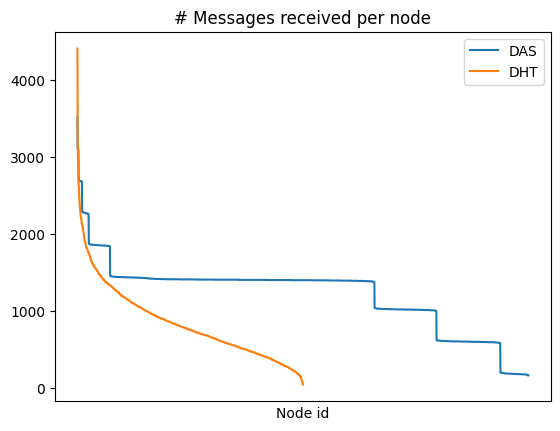

In [3]:
fig1, ax1 = plt.subplots()

for key in msg_df:
    #print(key)
    msg_types = msg_df[key]['type'].unique()
    msg_df2 = msg_df[key].loc[(msg_df[key]['dst'] != builder_address)]

    #for types in msg_types:
        #print(types)
    #    df2 = msg_df2.loc[(msg_df2['type'] == types)]
    #    df2['dst'].value_counts().plot(ax=ax1, kind='line', xticks=[], title="Message received by node", label=types+'_'+key)
        #print(df2['dst'].value_counts())
    msg_df2['dst'].value_counts().plot(ax=ax1, kind='line', xticks=[], title="Message received by node", label=key)

ax1.legend()

ax1.set_title("# Messages received per node")
ax1.set_xlabel("Node id")

In the following graph we observe the total number of messages generated during simulation time. 
We can observe in case of the DHT protocol, without limiting the number of ongoing requets, is generating an important
peak of traffic, an order of magnitude higher.
In case of limiting the number of ongoing requests, when using DHT, the peak of traffic is much lower, but this
implies that the process takes too long to complete, much longer than the block time, with the same number of total
messages but distributed over time.

Text(0.5, 0, 'Time')

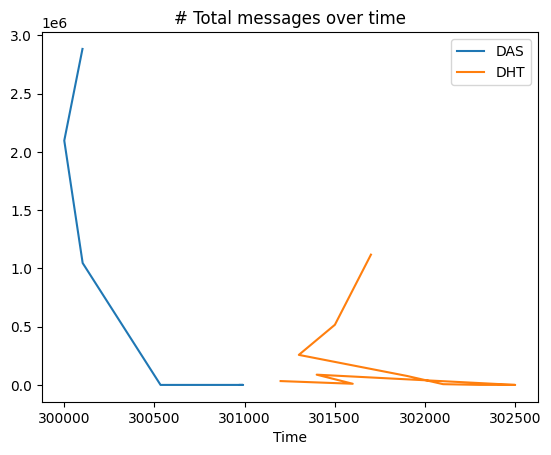

In [4]:
fig1, ax1 = plt.subplots()

for key in msg_df:
    msg_addr = msg_df[key]['dst'].unique()
    msg_df2 = msg_df[key].loc[(msg_df[key]['dst'] != builder_address)]

    msg_df2['time'].value_counts()[msg_df2.time.unique()].plot(ax=ax1,title="Total msgs received", label=key)
    #print(msg_df2['time'].value_counts()[msg_df2.time.unique()])

ax1.legend()

ax1.set_title("# Total messages over time")
ax1.set_xlabel("Time")

In the graph below we observe the number of messages again but distributed by type of messages.
MSG_RESPONSE messages are replies to MSG_FIND_DIST messages, but also to MSG_GET and MSG_PUT. 
DAS protocol only generates MSG_FIND_DIST and MSG_GET_SAMPLE and MSG_GET_SAMPLE_RESPONSE.
Vanilla DHT generates only MSG_FIND_DIST and MSG_GET and MSG_PUT, with an order of magnitude higher.

Text(0.5, 1.0, '# Total messages per type')

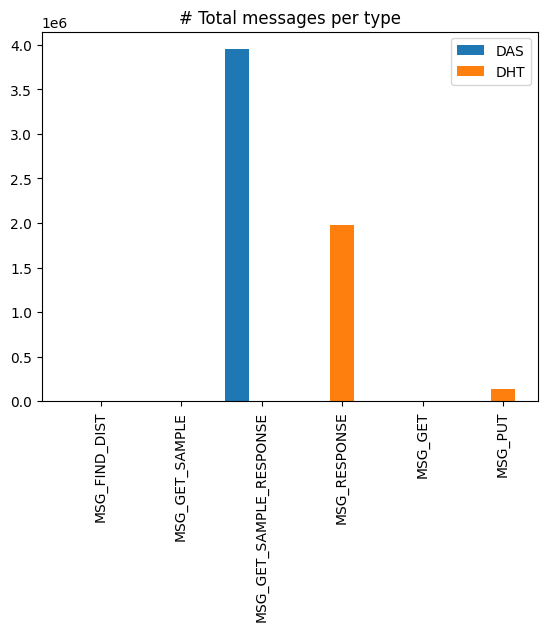

In [5]:
fig2, ax2 = plt.subplots()


i=-1

tables=['MSG_FIND_DIST','MSG_GET_SAMPLE','MSG_GET_SAMPLE_RESPONSE','MSG_RESPONSE','MSG_GET','MSG_PUT']
width=0.3
for key in msg_df:
    table={}
    for type in tables:
        table[type]= len(msg_df[key].loc[(msg_df[key]['type'] == type)])
        
    
    ax2.bar(np.arange(len(tables))+width*i,table.values(),width=width,label=key)

    i=i+1
ax2.legend()
ax2.set_xticks(range(len(tables)))
ax2.set_xticklabels(tables,rotation=90)

ax2.set_title("# Total messages per type")


This graph represents the CDF of the time required to complete the validator sampling process, for each solution.
DAS protocol performs the faster, within the 4 seconds limit for validators in all cases and below a second.
DHT without requests limit performs within the 4 seconds limit but much slower to our DAS protocol.
DHT with limit requests, is unable to perform sampling in a bounded time, requiring around between 20 and 50 seconds to complete the process.

Text(0.5, 0, 'Operation complete time (ms)')

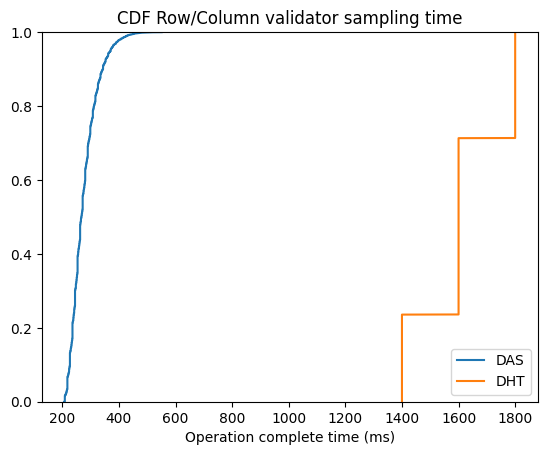

In [6]:
fig3, ax3 = plt.subplots()


for key in op_df:

    vsdf = op_df[key].loc[(op_df[key]['type'] == 'ValidatorSamplingOperation')]

    x = np.sort(vsdf['completion_time'])
    N = vsdf['completion_time'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)

    ax3.plot(x, y,label=key)

#ax3.set_xlim([0,4000])
ax3.legend()
ax3.set_ylim([0,1])

ax3.set_title("CDF Row/Column validator sampling time")
ax3.set_xlabel("Operation complete time (ms)")

This graph represents the number of hops (nodes contacted) required to complete the validator sampling process, for each solution.
DAS protocol is able to complete the process contacting only between 1 and 5 nodes in the network.
Vanilla DHT performs similar in both cases and needs to contact around 1000 nodes in average to complete
that validator sampling process.

Text(0.5, 0, '# hops')

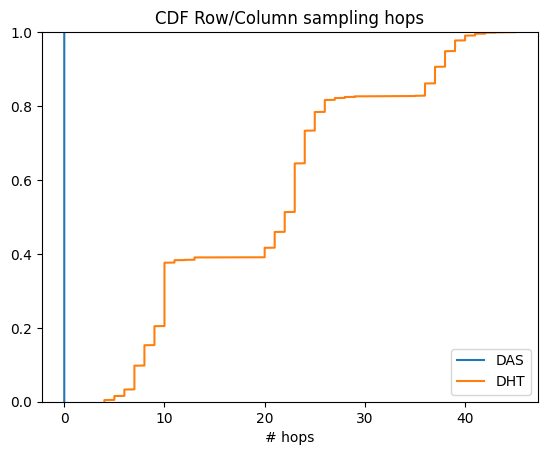

In [7]:
fig8, ax8 = plt.subplots()

for key in op_df:

    vsdf = op_df[key].loc[(op_df[key]['type'] == 'ValidatorSamplingOperation')]

    x = np.sort(vsdf['hops'])
    N = vsdf['hops'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)

    ax8.plot(x, y,label=key)

ax8.legend()
#ax8.set_xlim([0,10])
ax8.set_ylim([0,1])

ax8.set_title("CDF Row/Column sampling hops")
ax8.set_xlabel("# hops")

This graph represents the CDF of the time required to complete the random sampling process, for each solution.
In this case DHT without limits requests can perform faster than our solution.
This is caused by the fact that in this case random samples cannot be colocated in the same nodes and therefore
it is required to contact similar number of nodes to the number of samples required. Therefore limiting parallel requests by alpha means requirng more time, however the process can be completed with the time limit (8 seconds).
For DHT with requests limit the time required is higher than the time limit.


Text(0.5, 0, 'Operation complete time (ms)')

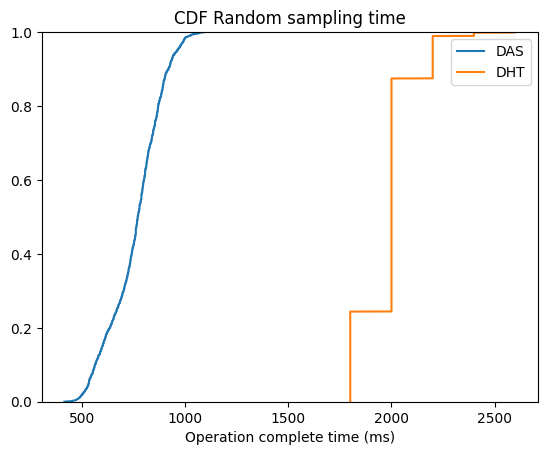

In [8]:
fig4, ax4 = plt.subplots()

for key in op_df:

    rsdf = op_df[key].loc[(op_df[key]['type'] == 'RandomSamplingOperation')]

    x = np.sort(rsdf['completion_time'])
    N = rsdf['completion_time'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)

    ax4.plot(x, y,label=key)

ax4.legend()
#ax4.set_xlim([0,8000])
ax4.set_ylim([0,1])

ax4.set_title("CDF Random sampling time")
ax4.set_xlabel("Operation complete time (ms)")

This graph represents the CDF of the number of hops required to complete the random sampling process, for each solution.
Our DAS protocol requires to contact below 75 nodes, much lower than vanilla DHT protocols
The difference between DHT protocols probably comes from the fact that doing it progressively can save hops required since routing tables, and therefore knowledge of the network, are filled with the multiple operations.

Text(0.5, 0, '# hops')

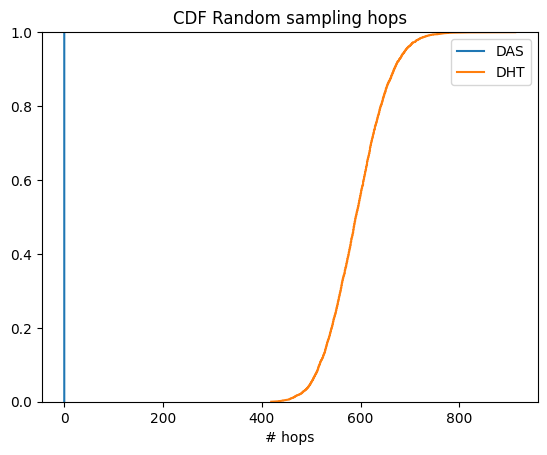

In [16]:
fig9, ax9 = plt.subplots()

for key in op_df:

    rsdf = op_df[key].loc[(op_df[key]['type'] == 'RandomSamplingOperation')]

    x = np.sort(rsdf['hops'])
    N = rsdf['hops'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)

    ax9.plot(x, y,label=key)

#ax9.set_xlim([0,1000])
ax9.set_ylim([0,1])
ax9.legend()
ax9.set_title("CDF Random sampling hops")
ax9.set_xlabel("# hops")

Text(0.5, 0, 'Number of samples obtained')

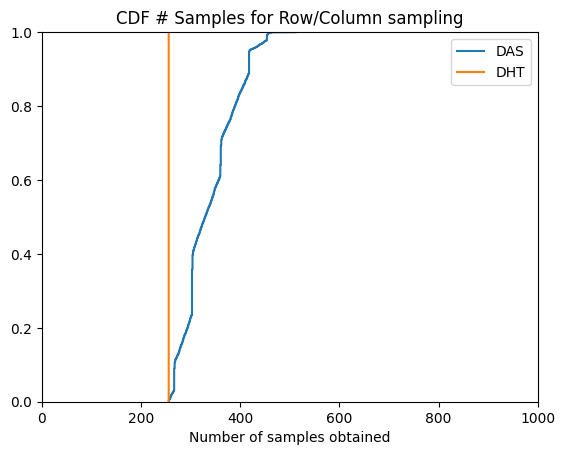

In [10]:
fig6, ax6 = plt.subplots()

for key in op_df:

    vsdf = op_df[key].loc[(op_df[key]['type'] == 'ValidatorSamplingOperation')]

    x = np.sort(vsdf['samples'])
    N = vsdf['samples'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)
    ax6.plot(x, y,label=key)

ax6.set_xlim([0,1000])
ax6.set_ylim([0,1])
ax6.legend()
ax6.set_title("CDF # Samples for Row/Column sampling")
ax6.set_xlabel("Number of samples obtained")

Text(0.5, 0, 'Number of samples obtained')

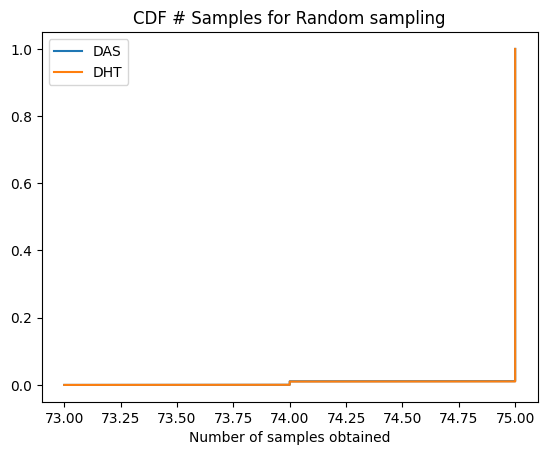

In [11]:
fig7, ax7 = plt.subplots()

for key in op_df:

    rsdf = op_df[key].loc[(op_df[key]['type'] == 'RandomSamplingOperation')]

    x = np.sort(rsdf['samples'])
    N = rsdf['samples'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)
    ax7.plot(x, y,label=key)

#ax6.set_xlim([0,4000])
ax7.legend()
ax7.set_title("CDF # Samples for Random sampling")
ax7.set_xlabel("Number of samples obtained")